## Class Activation Maps

In [2]:
# Analysis
import os
import glob
import numpy as np
import pandas as pd
import scipy

# Plotting
import PIL
from PIL import ImageDraw, Image
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

# Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

<a id='cam'></a>
>### Small IMG

CAM shows what parts of the image the model was paying attention to when deciding the class of the image by analyzing the **last Conv layer features** and **GAP weights**. 

#### Data

In [155]:
data = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = data.load_data()

In [156]:
print(f'Training set shape: X:{X_train.shape}, y:{y_train.shape}')
print(f'Test set shape: X:{X_test.shape}, y:{y_test.shape}')
print(f'There are {len(np.unique(y_train))} labels: {np.unique(y_train)}')
n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_classes = len(np.unique(y_train))

Training set shape: X:(60000, 28, 28), y:(60000,)
Test set shape: X:(10000, 28, 28), y:(10000,)
There are 10 labels: [0 1 2 3 4 5 6 7 8 9]


Class 9


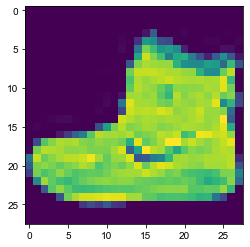

In [157]:
plt.imshow(X_train[0])
print(f'Class {y_train[0]}')

In [158]:
def preprocess(images): # for numpy arrays
    images = images.astype('float32') 
    images = images/255.0 
    images = images.reshape(-1,28,28,1) 
    return images

In [159]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

#### Model

In [160]:
# 全部设置same padding
model = keras.Sequential([
    layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same',input_shape=(28,28,1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(32, 3, activation='relu', padding='same'), 
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', padding='same'), 
    layers.MaxPooling2D(2),
    #取最后这层conv来看模型学到什么，对输出output贡献最active的地方
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    #把(w,h)求平均，从上一层(3,3,128)浓缩到(128)，每个feature用一个node代表
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation='softmax'), 
])

model.summary() 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 3, 128)        

In [161]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.1, shuffle=True)

Epoch 1/5
1688/1688 [==============================] - 53s 31ms/step - loss: 0.5999 - accuracy: 0.7780 - val_loss: 0.4316 - val_accuracy: 0.8445
Epoch 2/5
1688/1688 [==============================] - 47s 28ms/step - loss: 0.3668 - accuracy: 0.8660 - val_loss: 0.3240 - val_accuracy: 0.8763
Epoch 3/5
1688/1688 [==============================] - 48s 29ms/step - loss: 0.3072 - accuracy: 0.8885 - val_loss: 0.2887 - val_accuracy: 0.8938
Epoch 4/5
1688/1688 [==============================] - 50s 30ms/step - loss: 0.2753 - accuracy: 0.8995 - val_loss: 0.2916 - val_accuracy: 0.8932
Epoch 5/5
1688/1688 [==============================] - 48s 28ms/step - loss: 0.2498 - accuracy: 0.9071 - val_loss: 0.2901 - val_accuracy: 0.8918


#### CAM

In [162]:
#建立CAM模型，输出最后一层conv和最终output
cam_model = keras.Model(inputs=model.input,
                        outputs=(model.layers[-3].output,model.layers[-1].output)) 
cam_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12_input (InputLayer) [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 64)          0   

- The GAP layer encapsulate one neuron per feature from the last Conv layer, and passed to Dense layer
- Get the weights from the dense layer that follows the GAP layer.
- A particular class's weights determined how important each features is for that class (Class shoe will emphasize filters that look for shoelaces, etc)
- Each class's probability (10,) is the dot product of the encapsulated features (128,) and its own class weights (128,10), 

In [163]:
# 获得从GAP层到output层的参数
output_layer = model.layers[-1]
gap_weights = output_layer.get_weights()[0] #weights，TF的shape和我们学的方向相反
gap_bias = output_layer.get_weights()[1]
gap_weights.shape 
gap_bias.shape 

(128, 10)

(10,)

In [52]:
#把features(3,3,128)的(w,h)放大到原图大小(28,28)
features, y_pred = cam_model.predict(X_test)
features_scaled = scipy.ndimage.zoom(features[0], #以第0张图为例
                                     zoom=(28/3, 28/3,1), #分别乘以(w,h)的zoom系数
                                     order=2) #spline interpolation的次方，默认3
features_scaled.shape

(28, 28, 128)

**Class Activation Map** (28,28) is the dot product of scaled features (28x28x128) with each class's own weights (128,)
- For each class, we will get a (28,28) map, where each pixel value is the dot product representing the sum of weighted importance of each feature. 
- The scalar dot product will be large when the pixel finds a relevant feature (shoelace) that the particular class (shoe) heavily weighted on
- The scaled features can project the feature location back on the original image size 

In [184]:
# CAM显示class认为哪些features重要
def plot_cam(image_i):
    label = np.argmax(y_pred[image_i]) #得到某张图片的预测class
    prob = np.max(y_pred[image_i]) #预测概率
    true_label = y_test[image_i]
    weights = gap_weights[:,label] #获得该class的weights
    #放大最后一层Conv features到原图大小
    features_scaled = scipy.ndimage.zoom(features[image_i], (28/3, 28/3, 1), order=2) 
    cam  = np.dot(features_scaled, weights) #(28,28,128)@(128,）
    
    print(f'Predicted: {label} ({prob:.2%}), True: {true_label}')
    plt.figure(figsize=(10,4))
    # 原图
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(X_test[image_i],-1)) #(28,28,1)->(28,28)
    # CAM
    plt.subplot(1,3,2)
    color = 'Greens' if label==true_label else 'Reds' #预测正确时，显示绿色，否则红色
    plt.imshow(cam, cmap=color) #越重要的pixel值越大，越浅色，value大都在(5,15)左右
    # 混合
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(X_test[image_i],-1), alpha=0.5) #先半透明显示原图
    plt.imshow(cam, cmap=color, alpha=0.5) #在原图上面覆盖输出cam
    plt.show()
    
    
def plot_cams(desired_class, n):
    count = 0
    for i in np.random.permutation(n_test): #随机遍历所有图片
        if count == n: #只显示n张图
            break
        if np.argmax(y_pred[i]) == desired_class: #当该图预测的class是我想看的时候
            plot_cam(i)
            count += 1

- class 8 (handbag): outline or handle
- class 9 (ankle boot): heel

Predicted: 8 (100.00%), True: 8


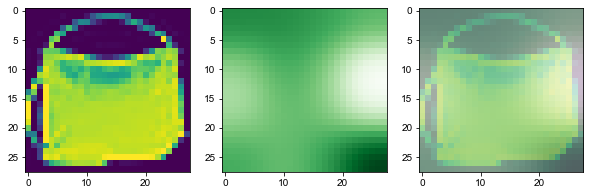

Predicted: 8 (99.78%), True: 8


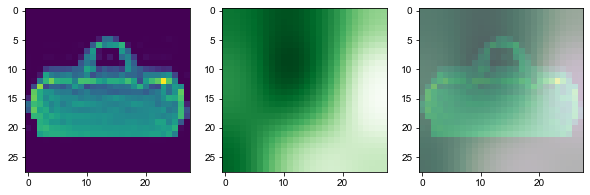

In [187]:
# Check desired class
plot_cams(desired_class=8, n=2)

>### Large IMG

CAM's visualization might look limited with small images, so here are the real photos.

In [10]:
from PIL import Image, ImageFont, ImageColor, ImageOps 
import tempfile
from six.moves.urllib.request import urlopen
import io
import tensorflow_datasets as tfds

#### Data

In [13]:
train = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test = tfds.load('cats_vs_dogs', split='train[90%:]', as_supervised=True)
train
validation
test

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [112]:
def preprocess(images, labels): 
    images = tf.cast(images, tf.float32) 
    images = tf.image.resize(images, (300, 300)) 
    images = images/255.0 
    return images, labels

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
def prepare_train_dataset(train):
    train = (train
             .map(preprocess)
             .shuffle(BUFFER_SIZE) 
             .batch(BATCH_SIZE) 
             .prefetch(AUTO)) 
    return train

def prepare_test_dataset(test):
    test = (test
            .map(preprocess) 
            .batch(BATCH_SIZE))
    return test

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1024
class_names = ['cat', 'dog']

In [14]:
train = prepare_train_dataset(train)
validation = prepare_test_dataset(validation)
test = prepare_test_dataset(test)
train
test

<PrefetchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>

<BatchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>

#### Model

In [15]:
# 全部设置same padding
model = keras.Sequential([
    layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same',input_shape=(300,300,3)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(32, 3, activation='relu', padding='same'), 
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', padding='same'), 
    layers.MaxPooling2D(2),
    #取最后这层conv来看模型学到什么，对输出output贡献最active的地方
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    #把(w,h)求平均，从上一层(3,3,128)浓缩到(128)，每个feature用一个node代表
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid'), 
])

model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       7

In [16]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'],
              optimizer=keras.optimizers.RMSprop(learning_rate=0.005))
history = model.fit(train, validation_data = validation, epochs=25)

Epoch 1/25
582/582 [==============================] - 1041s 2s/step - loss: 1.1903 - accuracy: 0.5164 - val_loss: 0.6925 - val_accuracy: 0.4819
Epoch 2/25
582/582 [==============================] - 994s 2s/step - loss: 0.6993 - accuracy: 0.5564 - val_loss: 0.6934 - val_accuracy: 0.5598
Epoch 3/25
582/582 [==============================] - 1013s 2s/step - loss: 0.6194 - accuracy: 0.6704 - val_loss: 0.5632 - val_accuracy: 0.7175
Epoch 5/25
582/582 [==============================] - 1024s 2s/step - loss: 0.6138 - accuracy: 0.6788 - val_loss: 0.6116 - val_accuracy: 0.6672
Epoch 6/25
582/582 [==============================] - 1019s 2s/step - loss: 0.5932 - accuracy: 0.6941 - val_loss: 0.5517 - val_accuracy: 0.7257
Epoch 7/25
582/582 [==============================] - 1010s 2s/step - loss: 0.5922 - accuracy: 0.7103 - val_loss: 0.5861 - val_accuracy: 0.6943
Epoch 8/25
582/582 [==============================] - 1039s 2s/step - loss: 0.5721 - accuracy: 0.7203 - val_loss: 0.5300 - val_accuracy: 

#### CAM

In [17]:
#建立CAM模型，输出最后一层conv和最终output
cam_model = keras.Model(inputs=model.input,
                        outputs=(model.layers[-3].output,model.layers[-1].output)) 
cam_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0     

In [116]:
# 获得从GAP层到output层的参数
output_layer = model.layers[-1]
gap_weights = output_layer.get_weights()[0] #weights，TF的shape和我们学的方向相反
gap_bias = output_layer.get_weights()[1]
gap_weights.shape 
gap_bias.shape 

(128, 1)

(1,)

In [75]:
def plot_metrics(history, string):
    plt.plot(history.history[string],label=string)
    plt.plot(history.history['val_'+string],label='val_'+string)
    plt.xlabel("Epochs")
    plt.title(string.capitalize())
    plt.legend()
    plt.show()

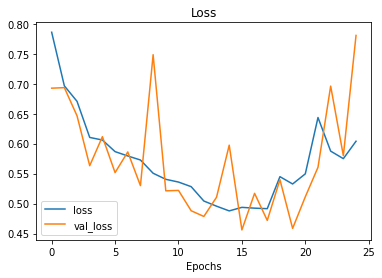

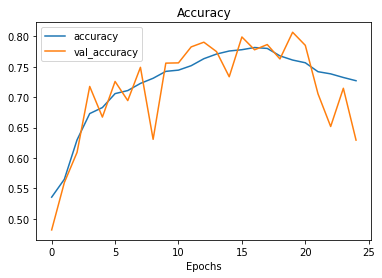

In [76]:
plot_metrics(history, 'loss')
plot_metrics(history, 'accuracy')

#### Prediction

In [119]:
def plot_cam(image, features, prob_pred, prob=None):
    prob_pred = prob_pred[0][0] #预测概率
    label = class_names[round(prob_pred)]
    true_label = class_names[prob] if prob!=None else "Unknown"
    weights = gap_weights[:,0] 
    features_scaled = scipy.ndimage.zoom(features[0], (300/37, 300/37, 1), order=2)
    cam  = np.dot(features_scaled, weights) #(300,300,128)@(128,）
    plt.imshow(image, alpha=0.5) #先半透明显示原图
    plt.imshow(cam, cmap='jet', alpha=0.3) #在原图上面覆盖输出cam
    plt.title(f'Predicted: {label} ({prob_pred if prob_pred>0.5 else 1-prob_pred:.2%}), True: {true_label}')
    plt.show()

Model actually distinguish cats and dogs by eyes and nose, while whiskers and a colar mostly point to a cat.

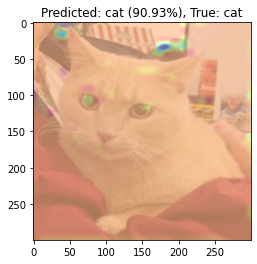

In [126]:
# Check test set
for images, probs in test.take(1):
    n = np.random.choice(BATCH_SIZE)
    image = images[n][np.newaxis,...] #原图已经normalize过了
    prob = probs[n]
    features, prob_pred = cam_model.predict(image)
    plot_cam(image[0], features, prob_pred, prob)

In [28]:
# 网上下载图片
def download_image(url, width=300, height=300, show=True):
    _, filepath = tempfile.mkstemp(suffix=".jpg") #创建临时文件，指定后缀，文件名随机，返回(数字，文件path)
    response = urlopen(url) #打开图片的http url
    image = response.read() #读取图片
    buffer = io.BytesIO(image) #保存到缓存 six.BytesIO, io.BytesIO
    pil_image = Image.open(buffer) #打开图片
    
    if (width and height): #需要resize时，否则返回原图尺寸
        pil_image = ImageOps.fit(pil_image, (width, height), Image.ANTIALIAS) #resize，同时如果新尺寸比例和原图不一致会crop
        #pil_image = pil_image.resize((width, height)) #resize，比例改变可能会变形
    pil_image = pil_image.convert("RGB") #以防万一确保是RGB
    
    pil_image.save(filepath, format="JPEG", quality=90) #保存到临时文件
    print(f'Image has been downloaded to {filepath}')
    if show:
        plt.imshow(pil_image)
    return filepath, pil_image

# 本地图片转成numpy
def image_to_numpy(path):
    image = Image.open(path)
    image = np.array(image).astype('uint8') 
    return image

In [29]:
# Check网上随机图片
TEST_IMAGES = [
    'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg',
    'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg',
    'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/catanddog.jpg',
    'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg',
    'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog2.jpg']

Image has been downloaded to /tmp/tmpo264v52r.jpg


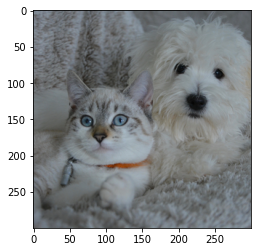

In [127]:
path, image = download_image(TEST_IMAGES[2])
image = image_to_numpy(path)
image = image[np.newaxis,...]/255
features, prob_pred = cam_model.predict(image)

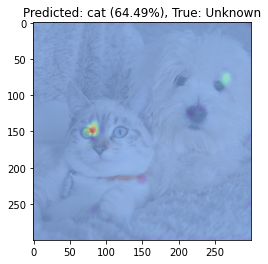

In [128]:
plot_cam(image[0], features, prob_pred)

In [107]:
model.save('cam_cats_and_dogs.h5')